## Joseph Rochelle
## DSC 550 Data Mining
## Orgional Case Study 2

In [1]:
import pandas as pd
from matplotlib import __version__ as mpv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
import numpy as np


**Link to data:** https://www.kaggle.com/lava18/google-play-store-apps?select=googleplaystore.csv

**Problem Statement:**

We live in a world where there are apps for everything. As a great idea emerges, a developer simply uploads the apps to Apple and Google stores for users to receive for free or to pay for service. Investors need predictive frameworks to predict high ratings and downloads, which can assist with determining if the app should be free, free with advertisements, or a paid service. By creating a predictive model, investors can access the mode of which the app should be uploaded to yield the strongest return on investment as the app is intended to scale. 


**Proposal of solutions:** 

By using the `google play store` data set, I will create three regression models: (a) un-regularized linear regression, (b) regularized linear regression, and (c) random forest regression. I will utilizes these three models in a cross-validated pipeline, by judging their performance on a data set by mean squared errors. After determining the best model, I will evaluate my final model (trained on the previous three training sets) to demonstrate an objective mdoel that should generalize well in the future. 

Using the paramaters found, I will train a final model using all the data and explore the most approriate strategy: If one of the regression models, the magniture of the coefficents will be examined; if it is the Random Forest regression model, the feature importance will be used. 

In [156]:
df= pd.read_csv("googleplaystore.csv")
df.head(5)

App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews  Size     Installs  Type Price Content Rating  \
0     159   19M      10,000+  Free     0       Everyone   
1     967   14M     500,000+  Free     0       Everyone   
2   87510  8.7M   5,000,000+  Free     0       Everyone   
3  215644   25M  50,000,000+  Free     0           Teen   
4     967  2.8M     100,000+  Free     0       Everyone   

                      Genres      Last Updated         Current Ver  \
0               Art & Design   January 7, 2018               1.0.0   
1  Art & Design;Pretend Play  January 15, 2018               2.0.0   
2               Art & Design    August 1, 2018               1.2.4   
3               Art & Design      June 8, 2018  Varies with device   
4    Art & Design;Creativity     June 20, 2018                 1.1   

    Android Ver  
0  4.0.3 and up  
1  4.0.3 and up  
2  4.0.3 and up  
3    4.2 and up  
4    4.4 and up

## Data Cleaning & EDA

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [158]:
df.shape

(10841, 13)

In [159]:
#Dropping Nulls to have equal parts per column
df.dropna(inplace= True)

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             9360 non-null   object 
 1   Category        9360 non-null   object 
 2   Rating          9360 non-null   float64
 3   Reviews         9360 non-null   object 
 4   Size            9360 non-null   object 
 5   Installs        9360 non-null   object 
 6   Type            9360 non-null   object 
 7   Price           9360 non-null   object 
 8   Content Rating  9360 non-null   object 
 9   Genres          9360 non-null   object 
 10  Last Updated    9360 non-null   object 
 11  Current Ver     9360 non-null   object 
 12  Android Ver     9360 non-null   object 
dtypes: float64(1), object(12)
memory usage: 1023.8+ KB


In [161]:
df.shape

(9360, 13)

**Functions to for data cleaning:** The purpose of this section is to focus on data cleaning the variables. These variables will transform to bianary classifications and the formats of sizing updated. In addiiton to the sizing, we will drop the #N/A and duplicates within this section as well as code shown above. 

In [162]:
# Cleaning Categories into integers
CategoryString = df["Category"]
categoryVal = df["Category"].unique()
categoryValCount = len(categoryVal)
category_dict = {}
for i in range(0,categoryValCount):
    category_dict[categoryVal[i]] = i
df["Category_c"] = df["Category"].map(category_dict).astype(int)

In [163]:
#scaling and cleaning size of installation
def change_size(size):
    if 'M' in size:
        x = size[:-1]
        x = float(x)*1000000
        return(x)
    elif 'k' == size[-1:]:
        x = size[:-1]
        x = float(x)*1000
        return(x)
    else:
        return None

df["Size"] = df["Size"].map(change_size)

#filling Size which had NA
df.Size.fillna(method = 'ffill', inplace = True)

In [164]:
#Cleaning no of installs classification
df['Installs'] = [int(i[:-1].replace(',','')) for i in df['Installs']]

In [165]:
#Converting Type classification into binary
#Used types.unique() to look at the data. 
def type_cat(types):
    if types == 'Free':
        return 0
    else:
        return 1

df['Type'] = df['Type'].map(type_cat)

In [166]:
#Cleaning of content rating classification
RatingL = df['Content Rating'].unique()
RatingDict = {}
for i in range(len(RatingL)):
    RatingDict[RatingL[i]] = i
df['Content Rating'] = df['Content Rating'].map(RatingDict).astype(int)

In [167]:
#Dropped columns that have no value
df.drop(labels = ['Last Updated','Current Ver','Android Ver','App'], axis = 1, inplace = True)

In [168]:
#Cleaning of genres
GenresL = df.Genres.unique()
GenresDict = {}
for i in range(len(GenresL)):
    GenresDict[GenresL[i]] = i
df['Genres_c'] = df['Genres'].map(GenresDict).astype(int)

In [169]:
#Cleaning prices
def price_clean(price):
    if price == '0':
        return 0
    else:
        price = price[1:]
        price = float(price)
        return price

df['Price'] = df['Price'].map(price_clean).astype(float)

In [170]:
# convert reviews to numeric
df['Reviews'] = df['Reviews'].astype(int)

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Category        9360 non-null   object 
 1   Rating          9360 non-null   float64
 2   Reviews         9360 non-null   int32  
 3   Size            9360 non-null   float64
 4   Installs        9360 non-null   int64  
 5   Type            9360 non-null   int64  
 6   Price           9360 non-null   float64
 7   Content Rating  9360 non-null   int32  
 8   Genres          9360 non-null   object 
 9   Category_c      9360 non-null   int32  
 10  Genres_c        9360 non-null   int32  
dtypes: float64(3), int32(4), int64(2), object(2)
memory usage: 731.2+ KB


In [172]:
df.head(4)

Category  Rating  Reviews        Size  Installs  Type  Price  \
0  ART_AND_DESIGN     4.1      159  19000000.0     10000     0    0.0   
1  ART_AND_DESIGN     3.9      967  14000000.0    500000     0    0.0   
2  ART_AND_DESIGN     4.7    87510   8700000.0   5000000     0    0.0   
3  ART_AND_DESIGN     4.5   215644  25000000.0  50000000     0    0.0   

   Content Rating                     Genres  Category_c  Genres_c  
0               0               Art & Design           0         0  
1               0  Art & Design;Pretend Play           0         1  
2               0               Art & Design           0         0  
3               1               Art & Design           0         0

In [19]:
# for dummy variable encoding for Categories. Not sure if this will be used yet. 
df2 = pd.get_dummies(df, columns=['Category'])

In [20]:
df2.head(4)

Rating  Reviews        Size  Installs  Type  Price  Content Rating  \
0     4.1      159  19000000.0     10000     0    0.0               0   
1     3.9      967  14000000.0    500000     0    0.0               0   
2     4.7    87510   8700000.0   5000000     0    0.0               0   
3     4.5   215644  25000000.0  50000000     0    0.0               1   

                      Genres  Category_c  Genres_c  ...  \
0               Art & Design           0         0  ...   
1  Art & Design;Pretend Play           0         1  ...   
2               Art & Design           0         0  ...   
3               Art & Design           0         0  ...   

   Category_PERSONALIZATION  Category_PHOTOGRAPHY  Category_PRODUCTIVITY  \
0                         0                     0                      0   
1                         0                     0                      0   
2                         0                     0                      0   
3                         0                     0                      0   

   Category_SHOPPING  Category_SOCIAL  Category_SPORTS  Category_TOOLS  \
0                  0                0                0               0   
1                  0                0                0               0   
2                  0                0                0               0   
3                  0                0                0               0   

   Category_TRAVEL_AND_LOCAL  Category_VIDEO_PLAYERS  Category_WEATHER  
0                          0                       0                 0  
1                          0                       0                 0  
2                          0                       0                 0  
3                          0                       0                 0  

[4 rows x 43 columns]

**Please Note:** 
I ran `df['Size'].unique()`  to validate that the sizing was updated correctly.  10472 converted from words to numbers and/or removed. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'ART_AND_DESIGN'),
  Text(1, 0, 'AUTO_AND_VEHICLES'),
  Text(2, 0, 'BEAUTY'),
  Text(3, 0, 'BOOKS_AND_REFERENCE'),
  Text(4, 0, 'BUSINESS'),
  Text(5, 0, 'COMICS'),
  Text(6, 0, 'COMMUNICATION'),
  Text(7, 0, 'DATING'),
  Text(8, 0, 'EDUCATION'),
  Text(9, 0, 'ENTERTAINMENT'),
  Text(10, 0, 'EVENTS'),
  Text(11, 0, 'FINANCE'),
  Text(12, 0, 'FOOD_AND_DRINK'),
  Text(13, 0, 'HEALTH_AND_FITNESS'),
  Text(14, 0, 'HOUSE_AND_HOME'),
  Text(15, 0, 'LIBRARIES_AND_DEMO'),
  Text(16, 0, 'LIFESTYLE'),
  Text(17, 0, 'GAME'),
  Text(18, 0, 'FAMILY'),
  Text(19, 0, 'MEDICAL'),
  Text(20, 0, 'SOCIAL'),
  Text(21, 0, 'SHOPPING'),
  Text(22, 0, 'PHOTOGRAPHY'),
  Text(23, 0, 'SPORTS'),
  Text(24, 0, 'TRAVEL_AND_LOCAL'),
  Text(25, 0, 'TOOLS'),
  Text(26, 0, 'PERSONALIZATION'),
  Text(27, 0, 'PRODUCTIVITY'),
  Text(28, 0, 'PARENTING'),
  Text(

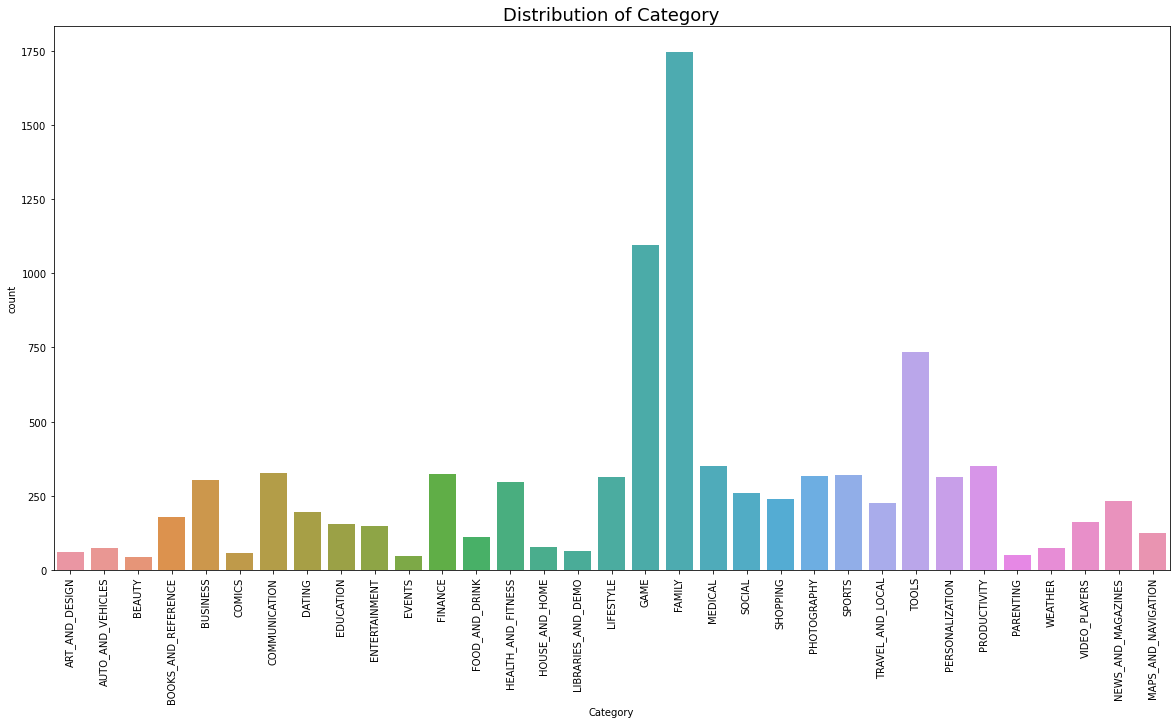

In [21]:
plt.figure(figsize=(20,10))
sns.countplot(x='Category',data=df)
plt.title("Distribution of Category", size=18)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'ART_AND_DESIGN'),
  Text(1, 0, 'AUTO_AND_VEHICLES'),
  Text(2, 0, 'BEAUTY'),
  Text(3, 0, 'BOOKS_AND_REFERENCE'),
  Text(4, 0, 'BUSINESS'),
  Text(5, 0, 'COMICS'),
  Text(6, 0, 'COMMUNICATION'),
  Text(7, 0, 'DATING'),
  Text(8, 0, 'EDUCATION'),
  Text(9, 0, 'ENTERTAINMENT'),
  Text(10, 0, 'EVENTS'),
  Text(11, 0, 'FINANCE'),
  Text(12, 0, 'FOOD_AND_DRINK'),
  Text(13, 0, 'HEALTH_AND_FITNESS'),
  Text(14, 0, 'HOUSE_AND_HOME'),
  Text(15, 0, 'LIBRARIES_AND_DEMO'),
  Text(16, 0, 'LIFESTYLE'),
  Text(17, 0, 'GAME'),
  Text(18, 0, 'FAMILY'),
  Text(19, 0, 'MEDICAL'),
  Text(20, 0, 'SOCIAL'),
  Text(21, 0, 'SHOPPING'),
  Text(22, 0, 'PHOTOGRAPHY'),
  Text(23, 0, 'SPORTS'),
  Text(24, 0, 'TRAVEL_AND_LOCAL'),
  Text(25, 0, 'TOOLS'),
  Text(26, 0, 'PERSONALIZATION'),
  Text(27, 0, 'PRODUCTIVITY'),
  Text(28, 0, 'PARENTING'),
  Text(

<Figure size 3600x1440 with 0 Axes>

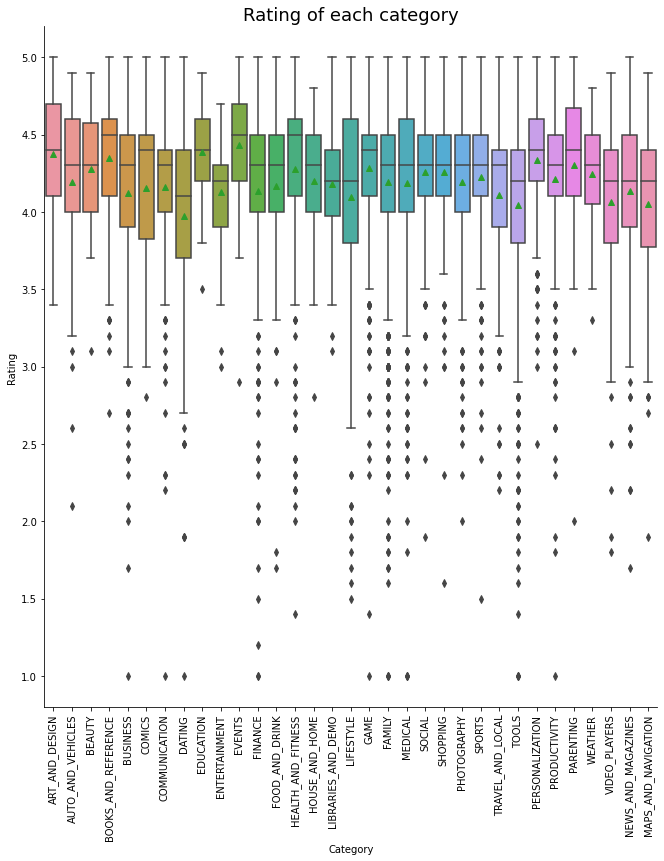

In [22]:
plt.figure(figsize=(50,20))
sns.catplot(x='Category',y='Rating',data=df,kind='box',height=10,showmeans=True)
plt.title("Rating of each category", size=18)
plt.xticks(rotation=90)

<AxesSubplot:xlabel='Content Rating', ylabel='Category'>

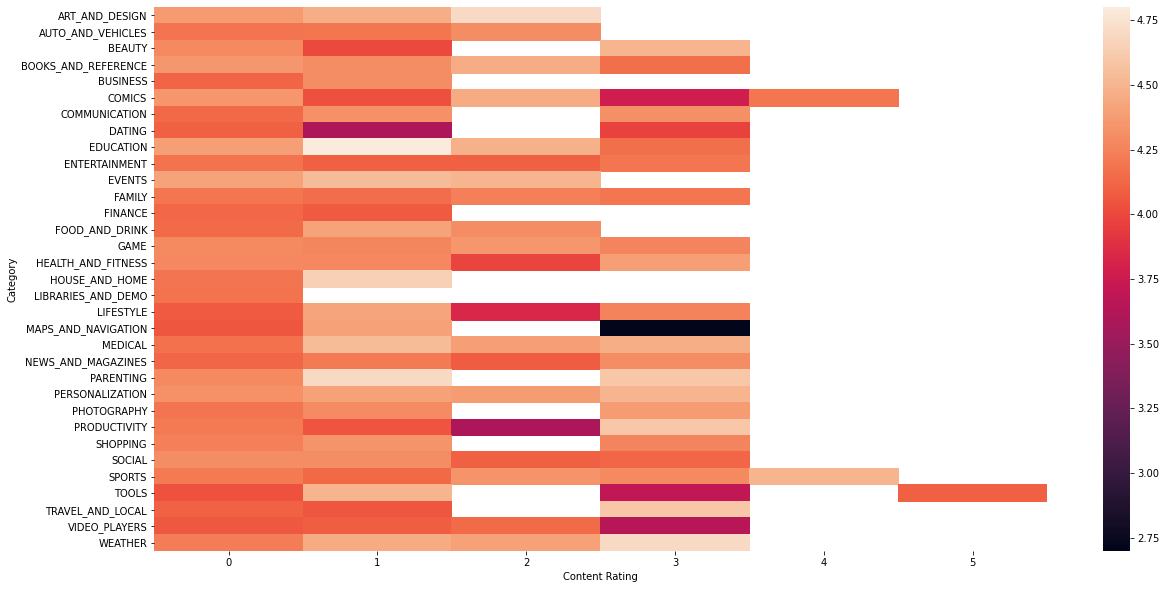

In [23]:
cat_con_rate = df.pivot_table(values='Rating',index='Category',columns='Content Rating')
plt.figure(figsize=(20,10))
sns.heatmap(cat_con_rate)

## **Pandas Profiling:** 

For this section, I utilized Panda's profilling which was a very fast and clean way to visualize EDA. It is important to note that I have done this one time on the main data that will need to be examined 3 additional times with the training data set.  For the purposes of this case study, I am keeping the current visualizations with the intent of deciding which hold the most value for the final.  This researcher is a fan of the Pandas Profiling to summarize the data quickly. 

In [24]:
from pandas_profiling import ProfileReport
prof = ProfileReport(df)
prof

**Discussion:**
Now that i have completed preprocessing and some EDA, I will focus on creating a pipeline that will be usd to cross validate the information.  The next goal is to evaluate the 


**Feature Selection using SelectFrom Model:** https://scikit-learn.org/stable/modules/feature_selection.html

**Links to future coding:** 
https://realpython.com/linear-regression-in-python/

https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

https://www.geeksforgeeks.org/random-forest-regression-in-python/

In [25]:
## Utilizing a correlation matrix to explore feature dimensionality and reduction as one technique. Anything above a 0.8 is highly correlated. 
#After reviewing, i am satisfied with the results. Please note that Category_c and Genre_c was transformed so naturally will show some higher correlations when converted to binary
# Pandas profilling was a faster and easier way to look at the correlation matrix for this weeks assignment. 
df.corr()

Rating   Reviews      Size  Installs      Type     Price  \
Rating          1.000000  0.068133  0.083154  0.051337  0.039592 -0.021919   
Reviews         0.068133  1.000000  0.149901  0.641605 -0.043244 -0.009824   
Size            0.083154  0.149901  1.000000  0.078248 -0.030452 -0.024785   
Installs        0.051337  0.641605  0.078248  1.000000 -0.053049 -0.011895   
Type            0.039592 -0.043244 -0.030452 -0.053049  1.000000  0.223344   
Price          -0.021919 -0.009824 -0.024785 -0.011895  0.223344  1.000000   
Content Rating  0.000862  0.060929  0.159105  0.028478 -0.034392 -0.016139   
Category_c     -0.026545 -0.013501 -0.040875  0.007837  0.049092 -0.014875   
Genres_c       -0.027970 -0.004510 -0.095311  0.025649  0.061286 -0.023562   

                Content Rating  Category_c  Genres_c  
Rating                0.000862   -0.026545 -0.027970  
Reviews               0.060929   -0.013501 -0.004510  
Size                  0.159105   -0.040875 -0.095311  
Installs              0.028478    0.007837  0.025649  
Type                 -0.034392    0.049092  0.061286  
Price                -0.016139   -0.014875 -0.023562  
Content Rating        1.000000   -0.094025 -0.094956  
Category_c           -0.094025    1.000000  0.844521  
Genres_c             -0.094956    0.844521  1.000000

## **Recursive Feature Elimination:** 
The purpose of recursive feature elimination is to examine the weights of the featres. First, the estimator is trained to look at the set of features and obtain the coef_ attributes that look at the feature importance. Then, the least important features from the current set are removed.  the `REFCV` is a cross-validation loop of the features. 

In [91]:
#Loading libries fro Recursive feature elimination
import warnings
from sklearn.datasets import make_regression
from sklearn.feature_selection import RFECV
from sklearn import datasets, linear_model


In [92]:
#Suppress warnings
warnings.filterwarnings(action="ignore", module="scipy",
                       message="^internal gelsd")

In [93]:
target= df['Rating']

In [94]:
features =df[['Reviews', 'Size','Installs','Type','Price','Content Rating','Category_c','Genres_c']]

In [95]:
#Generate feature matrix, target vector, and true coefficients

features, target = make_regression (n_samples=9360,
                                   n_features =8,
                                   n_informative = 2)

In [96]:
#Create a linear regression 
ols =linear_model.LinearRegression()

In [97]:
#Recursively eliminate features
rfecv= RFECV(estimator= ols, step =1, scoring = "neg_mean_squared_error")
rfecv.fit(features, target)
rfecv.transform(features)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


array([[-0.96545731, -0.76789945,  0.09186257, ..., -0.86540076,
        -0.1185355 , -0.95953895],
       [ 1.02131677, -0.54545072, -1.74500275, ...,  1.32531071,
        -0.23589122, -0.50140867],
       [ 0.9533824 , -0.79477393,  0.58168957, ..., -0.62505063,
         0.47577218,  1.46196245],
       ...,
       [ 0.07286212, -0.04644395, -0.39755349, ..., -1.71573046,
         0.63809242, -0.25088478],
       [ 0.08263896, -0.44134993, -0.5573944 , ..., -0.99436494,
         1.62129802, -0.19453077],
       [-0.12541681, -0.09436012, -0.29650113, ...,  0.11147069,
         1.77598834,  0.25730587]])

In [98]:
#Number of features we should keep
rfecv.n_features_

8

In [99]:
#Which categories are best. 
# I think this is Reviews, Size, and Installs
rfecv.support_

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [100]:
rfecv.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1])

In [101]:
#features =df[['Reviews', 'Size','Installs','Type','Price','Content Rating','Category_c','Genres_c']]

**Discussion:** For this part of the case study, I've learned that recursive elimination tells me how many features to keep or eliminate. I have 8 features and i believe it is telling me that all 8 are needed. 

## **Evaluating the Regression Models:**

To effectively evaluate regession models, the solution will be to use the mean squared error (MSE). MSE is the most common metric used to evaluate the regrssion models to predict the values. The higher the value of MSE, the worse the model is as the total squared error is high. Therefore, the model with the lowest MSE would be the model best suited for our predictive modeling. We will also evaluate the R2

The following solution can be used:

In [103]:
#Load libraries
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [108]:
#Generating features matrix,target vector
features, target =make_regression (n_samples = 100,
                                   n_features =3,
                                   n_informative =3,
                                   n_targets =1,
                                   noise= 50,
                                   coef = False,
                                   random_state=1)                                  

In [109]:
#Create a linear regression object
ols= LinearRegression()

In [110]:
#Cross-Validate the linear using Negative MSE
cross_val_score(ols, features, target, scoring = 'neg_mean_squared_error')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


array([-1718.22817783, -3103.4124284 , -1377.17858823])

In [111]:
#Using the coefficient of determination R2:
#Cross-validate the linear regression using R-Squared
cross_val_score(ols, features,target, scoring='r2')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.87804558, 0.76395862, 0.89154377])

## This section will be the train | split of unregular regression, regular regression, and Random Forest

The purpose of this section is to work ahead with writing code for fitting data to models. These models will be evaluated with the MSE through cross validations. 

Links to resources: https://www.kaggle.com/umutozdemir/comparison-of-different-regression-models

Links to resources: https://www.kaggle.com/sabanasimbutt/an-easy-approach-to-regularized-linear-regression

Links to resources: https://www.kaggle.com/celikagit/revenue-prediction-using-random-forest-regressor

Links to resources: https://www.kaggle.com/nsrose7224/random-forest-regressor-accuracy-0-91

#While i have a general idea now that i will evaluate the scores of all three models. I'm working through the understanding the arrays to process the models. 

## Regular Regression

In [150]:
#Multiple regression
import numpy as np
from sklearn.linear_model import LinearRegression

In [209]:
x = df[['Reviews', 'Size','Installs','Type','Price','Content Rating','Category_c','Genres_c']]
y= df['Rating']


In [210]:
x, y = np.array(x), np.array(y)

In [211]:
model = LinearRegression().fit(x, y)

In [178]:
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
print('\n')
print('intercept:', model.intercept_)
print('\n')
print('slope:', model.coef_)

coefficient of determination: 0.01409985660878954


intercept: 4.175168174203455


slope: [ 7.83589084e-09  1.68801835e-09  1.01729556e-10  1.08018409e-01
 -1.04224390e-03 -1.06112303e-02 -1.26201116e-03 -1.71322464e-04]


In [179]:
y_pred = model.predict(x)
print('predicted response:', y_pred, sep='\n')

predicted response:
[4.20724279 4.19868755 4.1910483  ... 4.15647301 4.1447697  4.1863897 ]


In [180]:
## Stats model
import numpy as np
import statsmodels.api as sm

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [181]:
x = sm.add_constant(x)

In [182]:
print(x)

[[1.00000e+00 1.59000e+02 1.90000e+07 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [1.00000e+00 9.67000e+02 1.40000e+07 ... 0.00000e+00 0.00000e+00
  1.00000e+00]
 [1.00000e+00 8.75100e+04 8.70000e+06 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 ...
 [1.00000e+00 4.00000e+00 3.60000e+06 ... 0.00000e+00 1.80000e+01
  1.20000e+01]
 [1.00000e+00 1.14000e+02 3.60000e+06 ... 3.00000e+00 3.00000e+00
  5.00000e+00]
 [1.00000e+00 3.98307e+05 1.90000e+07 ... 0.00000e+00 1.60000e+01
  2.80000e+01]]


In [183]:
print(y)

[4.1 3.9 4.7 ... 5.  4.5 4.5]


In [184]:
model = sm.OLS(y, x)

In [185]:
results = model.fit()

In [186]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     16.72
Date:                Sun, 25 Oct 2020   Prob (F-statistic):           7.33e-25
Time:                        19:18:04   Log-Likelihood:                -7007.9
No. Observations:                9360   AIC:                         1.403e+04
Df Residuals:                    9351   BIC:                         1.410e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1752      0.016    257.700      0.0

In [187]:
print('coefficient of determination:', results.rsquared)
print('adjusted coefficient of determination:', results.rsquared_adj)
print('adjusted coefficient of determination:', results.rsquared_adj)

coefficient of determination: 0.01409985660878954
adjusted coefficient of determination: 0.013256395893665007
adjusted coefficient of determination: 0.013256395893665007


## Random Forest 

In [188]:
## Random Forest
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 

In [189]:
data = df

In [216]:
data


Category  Rating  Reviews        Size  Installs  Type  \
0           ART_AND_DESIGN     4.1      159  19000000.0     10000     0   
1           ART_AND_DESIGN     3.9      967  14000000.0    500000     0   
2           ART_AND_DESIGN     4.7    87510   8700000.0   5000000     0   
3           ART_AND_DESIGN     4.5   215644  25000000.0  50000000     0   
4           ART_AND_DESIGN     4.3      967   2800000.0    100000     0   
...                    ...     ...      ...         ...       ...   ...   
10834               FAMILY     4.0        7   2600000.0       500     0   
10836               FAMILY     4.5       38  53000000.0      5000     0   
10837               FAMILY     5.0        4   3600000.0       100     0   
10839  BOOKS_AND_REFERENCE     4.5      114   3600000.0      1000     0   
10840            LIFESTYLE     4.5   398307  19000000.0  10000000     0   

       Price  Content Rating                     Genres  Category_c  Genres_c  
0        0.0               0               Art & Design           0         0  
1        0.0               0  Art & Design;Pretend Play           0         1  
2        0.0               0               Art & Design           0         0  
3        0.0               1               Art & Design           0         0  
4        0.0               0    Art & Design;Creativity           0         2  
...      ...             ...                        ...         ...       ...  
10834    0.0               0                  Education          18        12  
10836    0.0               0                  Education          18        12  
10837    0.0               0                  Education          18        12  
10839    0.0               3          Books & Reference           3         5  
10840    0.0               0                  Lifestyle          16        28  

[9360 rows x 11 columns]

In [217]:
x = data.iloc[:, 1:9].values


In [218]:
y = data.iloc[:,1].values   

In [219]:
y

array([4.1, 3.9, 4.7, ..., 5. , 4.5, 4.5])

In [203]:
from sklearn.ensemble import RandomForestRegressor 

In [204]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0) 

In [205]:
regressor.fit(x, y)   

ValueError: could not convert string to float: 'Art & Design'

In [212]:
Y_pred = regressor.predict(np.array([6.5]).reshape(1, 1)) 

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [220]:
# Visualising the Random Forest Regression results 
  
# arange for creating a range of values 
# from min value of x to max  
# value of x with a difference of 0.01  
# between two consecutive values 
X_grid = np.arange(min(x), max(x), 0.01)  
  
# reshape for reshaping the data into a len(X_grid)*1 array,  
# i.e. to make a column out of the X_grid value                   
X_grid = X_grid.reshape((len(X_grid), 1)) 
  
# Scatter plot for original data 
plt.scatter(x, y, color = 'blue')   
  
# plot predicted data 
plt.plot(X_grid, regressor.predict(X_grid),  
         color = 'green')  
plt.title('Random Forest Regression') 
plt.xlabel('Position level') 
plt.ylabel('Salary') 
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()